# The Project

In this opportunity we'll go through a very particular topic. We all know the lockdown during the COVID-19 is affecting all of us in different ways, but the most frequents are depression and anxiety which is an expected outcome - the natural responses to confinement are precisely these, and most of the people don't even know it. It's been a hard time, people are afraid of uncertainty, of losing their jobs as many people have already done, The conditions are met for a major emotional imbalance.

Experts recommend to stay away from social media because it accelerates the depression process, and who is depressed already will be even more, however people expressions on it are a key instrument to determine how a population is feeling. Most of the social media active people express how they feel in tweets, facebook posts, comments and even Instagram captions. So, starting from there, **can we determine if the depression and anxiety have increased during the lockdown implementing Machine Learning?**

The next project will cover several steps, but a 10000 feet overview would be:

* **Topic Modeling** - where we'll be looking for two labels: 1 - Depression & anxiety comments, 0 - Other
* **Topic Classification**

To achieve both tasks, we'll go through:

* **Data collection** - Getting data from different sources to accomplish the main objective.
* **Data cleaning** - We'll have to take all the data which is already in different formats and clean it up to then be able to use it.
* **Natural Language Processing for Topic Modeling** - We'll need to transform the text data into a type that can be interpreted by ML models.
* **Unsupervised Learning tasks for Topic Modeling** - This is crucial, because most of the data we can find out there is unlabeled, so we first need to identify patterns in it.
* **Supervised Learning tasks for Topic Classification**- Once the data is labeled, we'll go through several ML algorithms to finally select the one that delivers the best perfomance.
* Predict depression and anxiety in unseen tweets before and after lockdown
* Results' charting and conclusions


**The Depression & Anxiety Facebook comments dataset was obtained at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111060/ - for future references.**

**The COVID-19 tweets were acquired by myself implementing tweets scrapping. The dataset is composed by several tweets distribuited in the first week of the US lockdown**

# Imports

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

# Data exploration for Topic Modeling

Essentially what we'll do is to explore how the unlabeled data is to then preprocess it.

In [2]:
os.listdir('/kaggle/input')

['depression-anxiety-tweets', 'depression-and-anxiety-comments']

In [3]:
dataset = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
dataset.head()

,Comments Text
0,"So, when you ask what the two illnesses are......"
1,"In addition, people with BPD quite often have ..."
2,"Borderline Personality Disorder, like all othe..."
3,LONG ANSWER: Bipolar disease is caused by a ch...
4,Well think of bipolar as a rollar coaster you ...


In [4]:
dataset.shape

(7145, 1)

In [5]:
dataset.isnull().sum()

Comments Text    0
dtype: int64

Our first dataset contains 7145 entries without null values

# Data preprocessing for Topic Modeling

We need to apply some NLP tasks to prepare the data to be labeled. These are the main tasks:

* Remove URLs
* Remove emails
* Lowercase all text
* Remove punctuation signs
* Remove stop words
* Lemmatize text

In [6]:
#Removing URLs with a regular expression

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

for i in range(len(dataset)):
  dataset.at[i,'Comments Text'] = remove_urls(dataset.iloc[i]['Comments Text'])
dataset.head()

,Comments Text
0,"So, when you ask what the two illnesses are......"
1,"In addition, people with BPD quite often have ..."
2,"Borderline Personality Disorder, like all othe..."
3,LONG ANSWER: Bipolar disease is caused by a ch...
4,Well think of bipolar as a rollar coaster you ...


In [7]:
# Convert to list
data = dataset['Comments Text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['So, when you ask what the two illnesses are...theyre similar in that they tend to have moodiness involved, impulsivity and self-damaging behaviors for compensatory measures. Otherwise, theyre not really that similar, but they do seem to "like" one another and often show up in the same person...making their lives chaotic, difficult, dysfunctional, and intense. So, if your friend is concerned that they may have one (or both) of these illnesses, they should not be ashamed. Its definitely not their fault. They should, instead, get help from a professional...and INSIST that they are treated appropriately with the correct types of therapy and medication.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['so', 'when', 'you', 'ask', 'what', 'the', 'two', 'illnesses', 'are', 'theyre', 'similar', 'in', 'that', 'they', 'tend', 'to', 'have', 'moodiness', 'involved', 'impulsivity', 'and', 'self', 'damaging', 'behaviors', 'for', 'compensatory', 'measures', 'otherwise', 'theyre', 'not', 'really', 'that', 'similar', 'but', 'they', 'do', 'seem', 'to', 'like', 'one', 'another', 'and', 'often', 'show', 'up', 'in', 'the', 'same', 'person', 'making', 'their', 'lives', 'chaotic', 'difficult', 'dysfunctional', 'and', 'intense', 'so', 'if', 'your', 'friend', 'is', 'concerned', 'that', 'they', 'may', 'have', 'one', 'or', 'both', 'of', 'these', 'illnesses', 'they', 'should', 'not', 'be', 'ashamed', 'its', 'definitely', 'not', 'their', 'fault', 'they', 'should', 'instead', 'get', 'help', 'from', 'professional', 'and', 'insist', 'that', 'they', 'are', 'treated', 'appropriately', 'with', 'the', 'correct', 'types', 'of', 'therapy', 'and', 'medication']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['so', 'when', 'you', 'ask', 'what', 'the', 'two', 'illnesses', 'are', 'theyre', 'similar', 'in', 'that', 'they', 'tend', 'to', 'have', 'moodiness', 'involved', 'impulsivity', 'and', 'self', 'damaging', 'behaviors', 'for', 'compensatory', 'measures', 'otherwise', 'theyre', 'not', 'really', 'that', 'similar', 'but', 'they', 'do', 'seem', 'to', 'like', 'one', 'another', 'and', 'often', 'show', 'up', 'in', 'the', 'same', 'person', 'making', 'their', 'lives', 'chaotic', 'difficult', 'dysfunctional', 'and', 'intense', 'so', 'if', 'your', 'friend', 'is', 'concerned', 'that', 'they', 'may', 'have', 'one', 'or', 'both', 'of', 'these', 'illnesses', 'they', 'should', 'not', 'be', 'ashamed', 'its', 'definitely', 'not', 'their', 'fault', 'they', 'should', 'instead', 'get', 'help', 'from', 'professional', 'and', 'insist', 'that', 'they', 'are', 'treated', 'appropriately', 'with', 'the', 'correct', 'types', 'of', 'therapy', 'and', 'medication']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

stop_words = set(stopwords.words("english"))


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['ask', 'illness', 'be', 'similar', 'tend', 'moodiness', 'involved', 'impulsivity', 'self', 'damaging', 'behavior', 'compensatory', 'measure', 'otherwise', 'be', 'really', 'similar', 'seem', 'one', 'often', 'show', 'person', 'make', 'live', 'chaotic', 'difficult', 'dysfunctional', 'intense', 'friend', 'concern', 'may', 'illness', 'ashamed', 'definitely', 'fault', 'instead', 'get', 'help', 'professional', 'insist', 'treat', 'appropriately', 'correct', 'type', 'therapy', 'medication']]


In [12]:
dataset = []
for i in range(len(data_lemmatized)):
    dataset.append(" ".join(data_lemmatized[i]))
dataset = pd.Series(dataset)

# Data Vectorization for Topic Modeling

This step is crucial, otherwise our models that can only interpret numerical data won't be able to process our text, and we'll do it in a very particular way: we'll implement TFIDF vectorizer and CountVectorizer. The reason why we do this is to then compare NMF and LDA models' topics.

In [13]:
no_features = 15000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=no_features)
tfidf = tfidf_vectorizer.fit_transform(dataset)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(min_df=0.05,max_features=no_features)
tf = tf_vectorizer.fit_transform(dataset)
tf_feature_names = tf_vectorizer.get_feature_names()

# Model training

We'll explore how LDA and NMF can create the topics and depending on the outcomes we'll select the proper one for this project. Essentially we're looking for focused topics, otherwise the purpose of this project won't be reached.

The crucial difference between both models is that LDA adds a Dirichlet prior on top of the data generating process, meaning NMF qualitatively leads to worse mixtures, which could affect our dataset's topic quality. 

Regarding the library we'll be using: Scikit-Learn - the reasons are more than obvious, even when Gensim has more capabilities, it's also more complex and much more slower - we're looking to keep the things as simpler as possible and get results as quick as possible.

The outcome of this stage will be the original dataframe with its labels: 1 for depression/anxiety comments and 0 for other type of comments.

In [14]:
no_topics = 2

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5,max_iter=10000).fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

# Topics' Comparison

Let's see how coherent the topics are for each model. Remember we're looking for specifity, otherwise the classifier would get wrong results.

In [15]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 25
print('NMF')
display_topics(nmf, tfidf_feature_names, no_top_words)
print('LDA')
display_topics(lda, tf_feature_names, no_top_words)

NMF
Topic 0:
be, help, go, take, feel, get, know, time, med, make, try, thing, day, work, would, people, need, have, think, life, good, year, want, say, find
Topic 1:
anxiety, depression, depression anxiety, bipolar, anxiety depression, take, bipolar depression anxiety, bipolar depression, help anxiety, disorder, severe, help, work, anxiety attack, also, attack, severe anxiety, suffer, bipolar anxiety, symptom, med, anxiety disorder, high, anxiety take, bad
LDA
Topic 0:
be, feel, go, know, day, people, get, time, think, say, life, want, thing, have, make, would, struggle, even, love, try, can, understand, tell, good, way
Topic 1:
anxiety, take, help, med, work, depression, also, bipolar, get, need, find, medication, try, doctor, year, may, make, well, go, use, disorder, sleep, good, time, would


As you can see, NMF delivers better term mixtures for the topic 1 which is the one that cares us the most. Actually, if you read carefully the topic 1 you'll find out that it's what we were looking for since the beginning. Just because NMF is able to work with ngrams is the reason why we get better results and delivers depressive/anxious actual mixtures and not just terms about it.

Let's go more in depth and get all #1 labels for both models and see which one is more coherent.

# Dominant Topics' Extraction

Essentially what we'll do is to attach every document to its respective label.

In [16]:
# Create Document — Topic Matrix
lda_output = lda.transform(tf)
# column names
topicnames = ['Topic' + str(i) for i in range(lda.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(dataset))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic
dataset2 = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
df_document_topics.reset_index(inplace=True,drop=True)
dataset2['label'] = df_document_topics['dominant_topic']

In [17]:
dataset2.head()

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,1
4,Well think of bipolar as a rollar coaster you ...,0


In [18]:
# Create Document — Topic Matrix
nmf_output = nmf.transform(tfidf)
# column names
topicnames = ['Topic' + str(i) for i in range(nmf.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(dataset))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic
dataset1 = pd.read_excel('../input/depression-and-anxiety-comments/Depression  Anxiety Facebook page Comments Text.xlsx')
df_document_topics.reset_index(inplace=True,drop=True)
dataset1['label'] = df_document_topics['dominant_topic']

In [19]:
dataset1.head()

,Comments Text,label
0,"So, when you ask what the two illnesses are......",0
1,"In addition, people with BPD quite often have ...",0
2,"Borderline Personality Disorder, like all othe...",0
3,LONG ANSWER: Bipolar disease is caused by a ch...,0
4,Well think of bipolar as a rollar coaster you ...,0


Let's see all depressive/anxious comments labeled by NMF.

In [20]:
dataset1[dataset1['label']==1]

,Comments Text,label
14,"Yes, I've been seeing psychiatrists for nearly...",1
23,I'm a *itch 24/7 and I am not on medication b...,1
45,My wife left me about 9 months ago after a 8 y...,1
50,Hurtful question..n alot of insensitive commen...,1
54,My boyfriend has bipolar anxiety and anger iss...,1
...,...,...
7090,"I have more patoents,that work for direct tv, ...",1
7094,I am bp2 anxiety few other things on on ssdi,1
7099,I take Latuda at night because it makes me sle...,1
7121,This is me alot of the time however I got the ...,1


In [21]:
for i in range(20):
    print(dataset1[dataset1['label']==1].iloc[i][0])
    print('\n')

Yes, I've been seeing psychiatrists for nearly 30 years.  First just depression, then cyclothymia, then bipolar and anxiety, then BPD.


I'm a  *itch 24/7 and I am not on medication because I have no fking medical insurance for my bipolar, depression and anxiety so I have too deal with it myself and people around me, I can't stand who I am but I feel stuck like you, and hopeless


My wife left me about 9 months ago after a 8 year relationship. decided to jist pack up and leave on Christmas without warning because she couldn't deal with my anxiety and depression. It still hurts me but it will get better, you have to believe.  Hang in there.


Hurtful question..n alot of insensitive comments. Its not like we can help it.  So on top of hereditary mental health issues...i have to be forever single?  That works wonders on depression n anxiety. Thanks. :'(


My boyfriend has bipolar anxiety and anger issues so yes


I am in a relationship with my same sex partner which suffers from bipolar. 

In [22]:
dataset2[dataset2['label']==1]

,Comments Text,label
3,LONG ANSWER: Bipolar disease is caused by a ch...,1
14,"Yes, I've been seeing psychiatrists for nearly...",1
20,The only problem I have is when I'm randomly ...,1
29,"No, you are NOT alone. If my meds are not pro...",1
31,I too take Seroquel. It has done wonders for m...,1
...,...,...
7140,Please contact SADAG (south African depression...,1
7141,It gave me severe ataxia. (ataxia = People wi...,1
7142,I have. Caused muscles to tense up swelling an...,1
7143,Lamictal is my miracle med.Only took me 26 yea...,1


In [23]:
for i in range(20):
    print(dataset2[dataset2['label']==1].iloc[i][0])
    print('\n')

LONG ANSWER: Bipolar disease is caused by a chemical imbalance in the brain. It can be treated with medication and therapy. Typically people with bipolar disease have learned to compensate for it in unhealthy ways (illegal drug use, eating disorders, gambling, promiscuity, alcoholism, self harm, etc.) and therapy can assist them with overcoming these unhealthy "coping mechanisms." In addition, they may need therapy that assists with rebuilding family relationships that the sufferer (while in a relapse state) has damaged. Bipolar disease often causes lability of emotional response and potentially self-damaging behaviors that come from that. They tend to have periods of mania/hypomania and depression that is severe. During mania, they may feel like they have more energy, be happier (without reason), have grandiose ideas of themself and their abilities, need less sleep, be much more sexual, and engage in risky behaviors without considering the consequences. During depression, they may be 

As you can see, NMF delivers better results because it's more specific and really determines depressive/anxious comments meanwhile LDA labels all entries that contain depression/anxiety related words and it makes the labeling more general. **Let's keep NMF's results.**

As you can see above, now the dataset is properly labeled; the label 1 - Depression & Anxiety-  is pretty coherent. Even when label 0 still contains text with relevant words, if you deep dive into it you'll notice the entries don't seem to be comments related to Depression & Anxiety. Said that, let's move on: It's time now to classify tweets.

# Data preprocessing for Topic Classification

As you could see before, our text processing pipeline did very well its task, so we'll use it again to feed and fit our classifier.

In [24]:
output = []
for i in range(len(data_lemmatized)):
    output.append(" ".join(data_lemmatized[i]))
output = pd.DataFrame(output,columns=['Text'])
output['label'] = df_document_topics['dominant_topic']

# Model Selection for Topic Classifier

Alright, we've been doing some topic modeling to finally reach this point. Essentially what we'll do is to train several vectorizers and supervised ML models to get a very accurate result to then predict tweets' topics from a dataset that we'll be using later on this notebook. Btw, we'll skip Random Forest model because it's known to overfit the text data and deliver poor metrics.

In [25]:
#Splitting our data
X = output['Text']
y = output['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [26]:
#checking if everything went OK.
print (len(X_train),len(X_test),len(y_train),len(y_test))

5358 1787 5358 1787


## SGD Classifier

We'll start with this classifier, which is very famous at Kaggle because of very good predictions. Let's implement a pipeline to get the best parameters.

In [27]:
# Defining the pipeline - a text feature extractor with a classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will increase processing time exponentially. Only do if you have hardware enough.

parameters = {
    'vect__max_df': (0.5, 0.75),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,1),(1,2),(1,3)),  #Tried already with bigrams, trigrams and the best result always was achieved with (1,1) for all models so, in order to reduce computing time, only will keep this.
     'tfidf__use_idf': (True, False),
     'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (50,100),
    'clf__alpha': (0.00001, 0.000001,0.0000001,),
    'clf__penalty': ('l2', 'elasticnet'),
}

In [28]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06, 1e-07),
 'clf__max_iter': (50, 100),
 'clf__penalty': ('l2', 'elasticnet'),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  8.5min finished


done in 511.016s

Best score: 0.981
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 50
	clf__penalty: 'l2'
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


As you noticed above, the classifier reached an acceptable score. Let's see how it behaves in the test data.

In [29]:
vect = CountVectorizer(max_df=0.5,  ngram_range=(1,2))

X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

transformer = TfidfTransformer(smooth_idf=True,use_idf=False,norm='l1')
X_train_vectorized = transformer.fit_transform(X_train_vectorized)
X_test_vectorized = transformer.transform(X_test_vectorized)


clf = SGDClassifier(alpha=1e-05,max_iter=100,penalty='elasticnet').fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [30]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 89.12%
Accuracy: 97.82%
Recall: 94.25%
AUC score: 96.29%


Not bad, it's our first model to be tested. Let's see its confusion matrix.

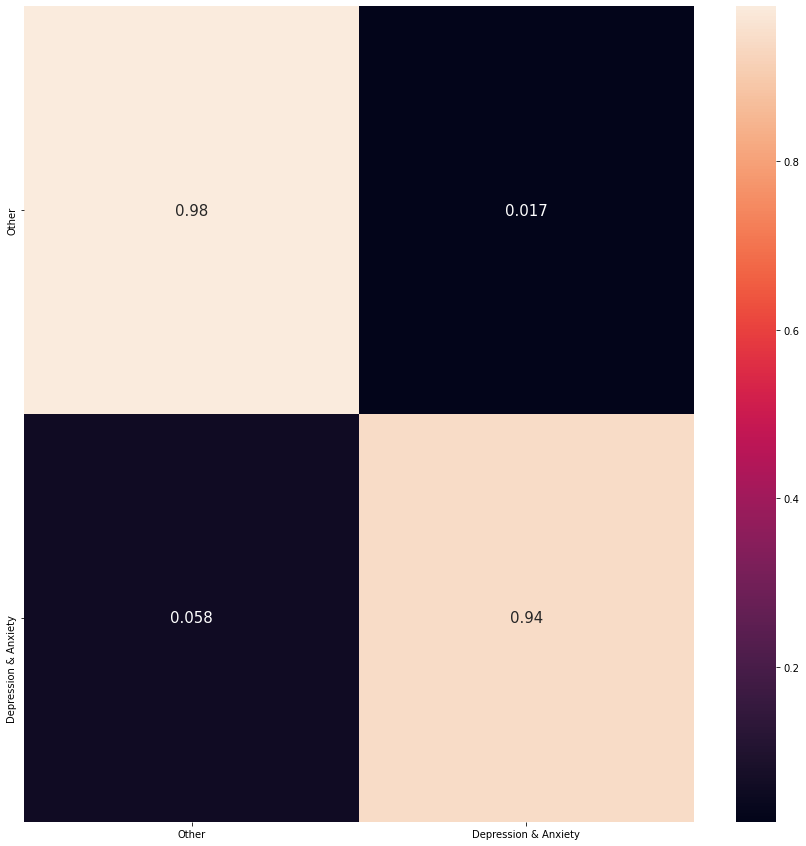

In [31]:
matrix = confusion_matrix(y_test, y_predicted)
conf_matrix = pd.DataFrame(matrix, index = ['Other','Depression & Anxiety'],columns = ['Other','Depression & Anxiety'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Seems to have a very good generalization hability. Let's see some other models.

## Support Vector Classifier

SVC is by default a very good model, let's see how it behaves in our pipeline.

In [32]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

parameters = {
    'vect__max_df': (0.5,),
    'vect__ngram_range': ((1,1),(1,2),(1,3)),
    'clf__gamma': (1,0.1),
     'tfidf__use_idf': (True, False),
     'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (100,200),
    "clf__C": [1,10,100],
}

In [33]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': [1, 10, 100],
 'clf__gamma': (1, 0.1),
 'clf__max_iter': (100, 200),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5,),
 'vect__ngram_range': ((1, 1), (1, 2), (1, 3))}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  6.1min finished


done in 365.273s

Best score: 0.979
Best parameters set:
	clf__C: 1
	clf__gamma: 0.1
	clf__max_iter: 200
	tfidf__norm: 'l2'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


It reached intermediate metrics, let's see how it performs on the test data.

In [34]:
vect = CountVectorizer(max_df=0.5,  ngram_range=(1,1))

X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

#transformer = TfidfTransformer(smooth_idf=True,use_idf=False,norm='l1')
#X_train_vectorized = transformer.fit_transform(X_train_vectorized)
#X_test_vectorized = transformer.transform(X_test_vectorized)

clf = SVC(C=1,max_iter=200,gamma=0.1).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [35]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 87.77%
Accuracy: 97.03%
Recall: 88.94%
AUC score: 93.57%


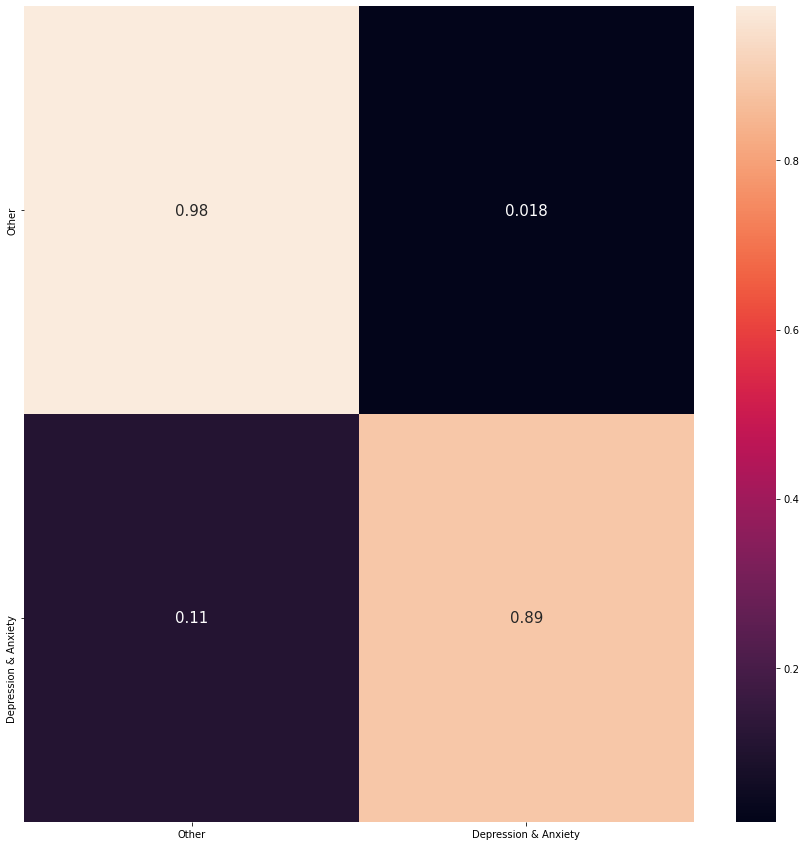

In [36]:
matrix = confusion_matrix(y_test, y_predicted)
conf_matrix = pd.DataFrame(matrix, index = ['Other','Depression & Anxiety'],columns = ['Other','Depression & Anxiety'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Terrible metrics, huh? We can't deal with those FPs and FNs. What I think is that we're implementing too complex models and that's why they're overfitting the data. Let's try with one of the most simple models out there.

## Logistic Regression Classifier

In [37]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,2),(1,3),),
     'tfidf__use_idf': (True, False),
     #'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (100,),
    "clf__C": [0.1, 1, 10, 100,1000],
}

In [38]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': [0.1, 1, 10, 100, 1000],
 'clf__max_iter': (100,),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 2), (1, 3))}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


done in 294.422s

Best score: 0.981
Best parameters set:
	clf__C: 10
	clf__max_iter: 100
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [39]:
vect = CountVectorizer(max_df=0.5,  ngram_range=(1,2))

X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

transformer = TfidfTransformer(smooth_idf=True,use_idf=False,norm='l1')
X_train_vectorized = transformer.fit_transform(X_train_vectorized)
X_test_vectorized = transformer.fit_transform(X_test_vectorized)


clf = LogisticRegression(max_iter=100,C=100).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [40]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 88.89%
Accuracy: 97.93%
Recall: 95.58%
AUC score: 96.92%


Precision is pretty low, but accuracy and the Area Under the Curve are showing that maybe this model can be helpful. Let's plot its confusion matrix and see how well it did.

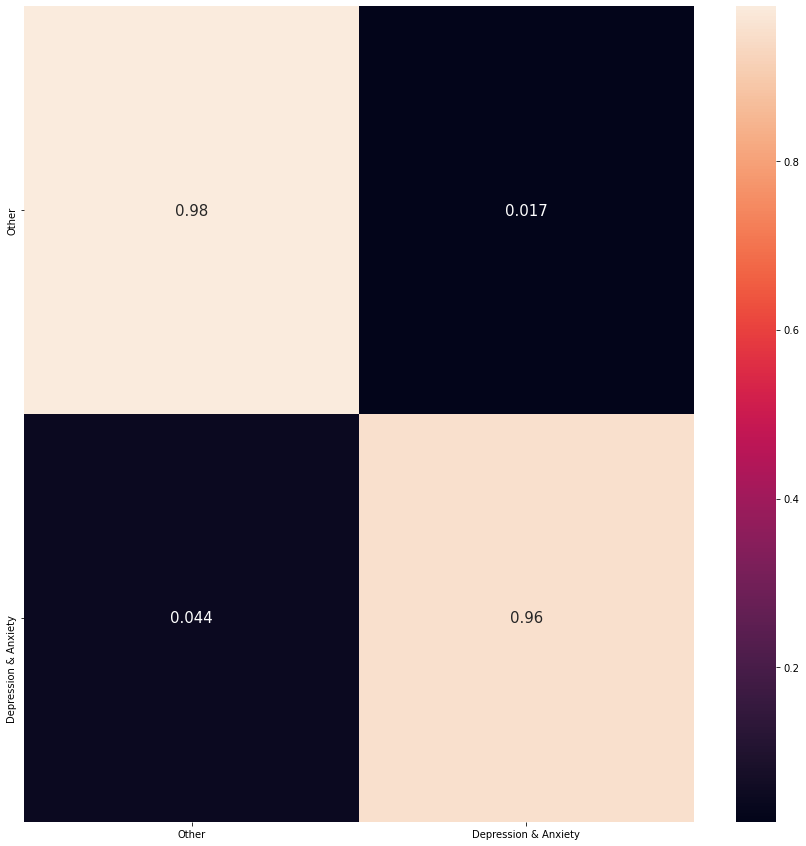

In [41]:
matrix = confusion_matrix(y_test, y_predicted)
conf_matrix = pd.DataFrame(matrix, index = ['Other','Depression & Anxiety'],columns = ['Other','Depression & Anxiety'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Not bad, at all. This simplest model is the one that delivers one of the best metrics. We'll keep this model because it fits the data very quick and for our purposes this one behaves more than good. We can deal with the FPs and FNs misclassified by this predictor. We are all set to start importing the tweets data.

## Model selected: LogisticRegression classifier

# Depressive/Anxious tweets import and exploration

Alright, we're about to explore a dataset that I've acquired implementing OMGOT script - It's essentilly a Python code to get tweets without the need of using the Twitter API. Why did I do it this way? Because in order to use the Twitter API you need a developer account and you all know how complex is to get it approved. However, the mentioned script allows you to get whatever the tweets you want, in the location you want and with the keywords that you want. 

The dataset is made up of several CSV files, each one containing all available tweets related to depression and anxiety topics. We've limited them because would get complex to measure our model in a dataset that contains spread content. Also, the dataset contains tweets from 03/14 to 03/27 - one week before and after the lockdown started along US. Let's see what patterns we can find.

In [42]:
os.listdir('/kaggle/input/depression-anxiety-tweets/Tweets data')[:5]

['0315_5.csv', '0319_4.csv', '0318_4.csv', '0320_3.csv', '0327_2.csv']

In [43]:
tweets = pd.read_csv('/kaggle/input/depression-anxiety-tweets/Tweets data/0314_1.csv')
tweets.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2020-03-14 23:55:21,AlbertoxVazquez,NaN,0,1,5,Bout to depression buy these OnlyFans while I’...,NaN,NaN,NaN,1238977045230739460,https://twitter.com/AlbertoxVazquez/status/123...
1,2020-03-14 23:54:45,TheOGKennedy,NaN,6,2,63,Pretty lucky for me how we ended up in the onl...,NaN,NaN,NaN,1238976896160772096,https://twitter.com/TheOGKennedy/status/123897...
2,2020-03-14 23:45:58,megmarie5,NaN,0,0,0,@ariana2525 I myself suffered & still suffer. ...,NaN,@ariana2525,NaN,1238974685015990273,https://twitter.com/megmarie5/status/123897468...
3,2020-03-14 23:43:10,BoozyBillsBabe,NaN,13,0,39,Second full day of self-quarantine and I am ju...,NaN,NaN,NaN,1238973978963836928,https://twitter.com/BoozyBillsBabe/status/1238...
4,2020-03-14 23:42:39,megmarie5,NaN,0,0,1,I’m behind on @VanderpumpRules and binge watch...,NaN,@VanderpumpRules @ariana2525,NaN,1238973850227884032,https://twitter.com/megmarie5/status/123897385...


It's time to explain how the dataset is composed. I queried several tweets from the beginning of the lockdown at US. I focused on downloading tweets that contain the keywords 'Anxiety', 'Depression', 'Anxious' and 'Depressive' in order to limit the topics, otherwise these would be very general. Let's put them all on a same dataframe to start the exploration.

In [44]:
for dirname, _, filenames in os.walk('/kaggle/input/depression-anxiety-tweets/Tweets data'):
    for filename in filenames:
        if filename!='0314_1.csv':
            temp = pd.read_csv(os.path.join(dirname, filename))
            tweets = pd.concat([tweets, temp], ignore_index=True)

In [45]:
tweets.shape

(25425, 12)

In [46]:
tweets.sort_values(by=['date'],inplace=True)
tweets.reset_index(drop=True,inplace=True)
tweets = tweets[['date','text']]

In [47]:
tweets.head()

,date,text
0,2020-03-14 00:04:13,Damn just remembered this front bottoms show i...
1,2020-03-14 00:07:19,"hapless Dementia joe will lose to Trump, even ..."
2,2020-03-14 00:07:52,it's making me anxious lol
3,2020-03-14 00:08:46,I’m so glad my depression kicked in I’m going ...
4,2020-03-14 00:11:16,Have some wine . You’ll feel less anxious.


In [48]:
#Removing non-ascii characters (for example, arabian chars)
tweets.text.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
#Making all fields string type
for i in range(len(tweets)):
  tweets.at[i,'text'] = str(tweets.iloc[i]['text'])
#Removing URLs
for i in range(len(tweets)):
  tweets.at[i,'text'] = remove_urls(tweets.iloc[i]['text'])
# Convert to list
data = tweets.text.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
#Sentence splitting
data_words = list(sent_to_words(data))
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)
# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#Putting all together
dataset = []
for i in range(len(data_lemmatized)):
    dataset.append(" ".join(data_lemmatized[i]))
dataset = pd.Series(dataset)
dataset = pd.concat([tweets['date'], dataset], axis=1)
dataset.rename(columns={'date':'Date',0:'Text'},inplace=True)

In [49]:
dataset.head(15)

,Date,Text
0,2020-03-14 00:04:13,damn remember front bottom show cure depression
1,2020-03-14 00:07:19,dementia lose trump even economy crater full d...
2,2020-03-14 00:07:52,make anxious lol
3,2020-03-14 00:08:46,be kick be go bed
4,2020-03-14 00:11:16,wine will feel less anxious
5,2020-03-14 00:12:38,patient message blow know anxious bet mini wri...
6,2020-03-14 00:14:19,can wait tell kid depression
7,2020-03-14 00:14:34,think order keep sick hourly worker home suppo...
8,2020-03-14 00:14:57,
9,2020-03-14 00:15:00,right dedication prove city sustain market dep...


## Vectorizing tweets dataset

In [50]:
text_vector = vect.transform(dataset['Text'])

## Getting dataset labels

In [51]:
labels = clf.predict(text_vector)
dataset['Label'] = labels
tweets['Label'] = dataset['Label']
tweets.head()

,date,text,Label
0,2020-03-14 00:04:13,Damn just remembered this front bottoms show i...,1
1,2020-03-14 00:07:19,"hapless Dementia joe will lose to Trump, even ...",0
2,2020-03-14 00:07:52,it's making me anxious lol,0
3,2020-03-14 00:08:46,Im so glad my depression kicked in Im going to...,0
4,2020-03-14 00:11:16,Have some wine . Youll feel less anxious.,0


Let's print some random depressive/anxious tweets.

In [52]:
for i in range(0,50,10):
    print(tweets[tweets['Label']==1].iloc[i][1])
    print('\n')

Damn just remembered this front bottoms show is about to cure my depression


Amerie went home sick w/ a cough and 103 fever. I had an anxiety attack. Here at urgent care & she tested negative for the flu, but dr says its the flu. But not corona. I asked to test for corona and she said we dont have it. Theres a limited amount in the us. ?THANKS TRUMP


Still in awe of @joywave There's someone here that you should meet My pet, he cures anxiety ("It's for therapy!")


Anxiety sucks.... tired of living with feeling so anxious especially when its out of no where.


We sure do need the tested team rn to keep our minds busy. Thank you all so much. Signed chronic constant anxiety bearers.




The predictions look very well, but also very sad! It's the demonstration that there are many people out there having serious issues. Obviously there are some tweets that are related to other type of depression, but most of them are about actual depressive and anxious people. Let's get more info about this.

Let's put some data together to plot a curve about the actual number of depressive/anxious tweets against the whole tweets dataset.

**IMPORTANT** The OMGOT script downloaded all available tweets with the specification given. We'll be basing our research on a unbalanced and very irregular dataset, just FYI. In addition, it's just to measure how well our model performs, the rest of the research is just informative and not with science purposes.

In [53]:
for i in range(len(dataset)):
    dataset.at[i,'Date'] = dataset.iloc[i]['Date'][0:10]
tweets_per_day = dataset['Date'].value_counts().sort_index()[0:-6]
tweet_pred = dataset.groupby(['Date']).sum()[0:-6]
dates = []
for i in range(len(tweet_pred)):
    dates.append(datetime.strptime(tweet_pred.index.values[i], '%Y-%m-%d'))

How does look the depression/anxiety curve per day both weeks? Is there any pattern here? Any less depressive day compared to the others?

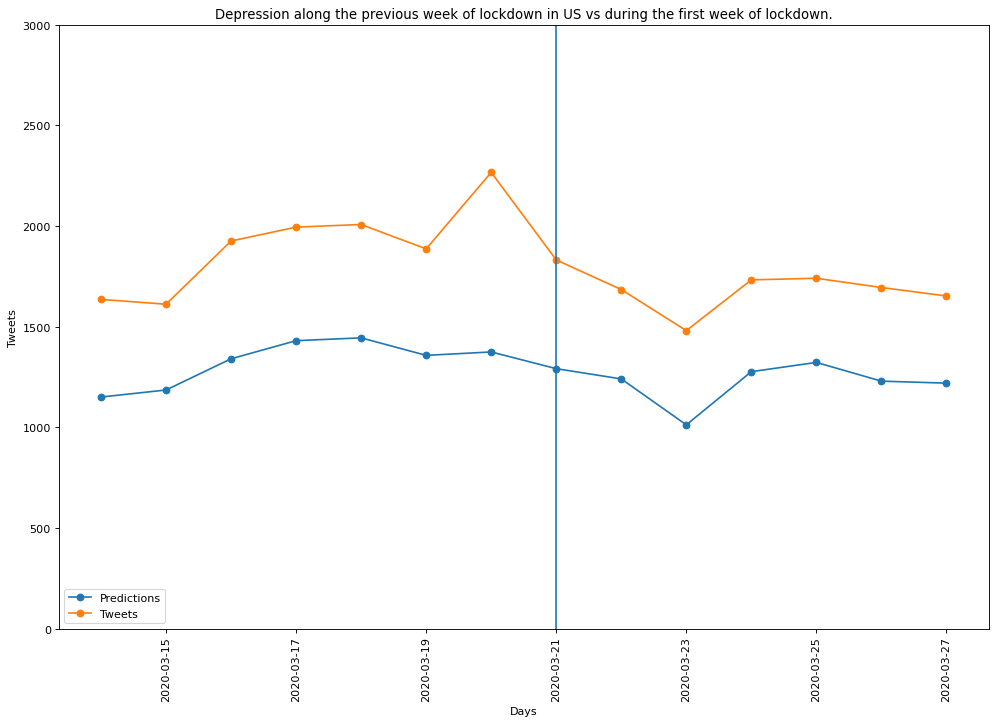

In [54]:
X_axis = np.array(dates)
Y_axis = tweet_pred['Label']

plt.figure(figsize=(15, 10), dpi=80)
plt.title('Depression along the previous week of lockdown in US vs during the first week of lockdown.')
plt.plot(X_axis,Y_axis,marker='o')
plt.plot(X_axis,tweets_per_day.values,marker='o')
plt.xlabel('Days')
plt.ylabel('Tweets')
plt.axvline(x=datetime.strptime('2020-03-21', '%Y-%m-%d'))
plt.xticks(rotation=90)
plt.legend(['Predictions','Tweets'],loc=3)
plt.ylim(0, 3000)
plt.show()

There are a few things to extract from the above's chart:

**We would need to get more data and also for more days, but some premature thoughts would be:**

* The predictions follow the trend of the dataset in most of the days, which is made up of tweets that contain keywords related to depression and anxiety but not are not necessarily depressive/anxious tweets.
* Even when the dataset has a peak on 03/20, the predictions don't follow the trend this day. That only means our model is filtering depressive/anxious tweets properly. This day people could be tweeting about "Great Depression" which we know was a world TT but is not related to actual depression, just economy depression.
* Weekends are less depressive - which makes sense. Important researches have confirmed that the less depressive day for the americans is Saturday.
* We cannot make an affirmation, but looks like the lockdown has decreased the anxiety and depression on americans, at least on the first week of lockdown. That could make sense, people would be at home with their families and not having to deal with outside people - which generates high volumes of anxiety for introvert individuals.
* Week days are the ones that generate more anxiety and depression on americans, with peak on wednesdays.

Let's get some data about **time** to find out more trends.

Extracting the hour stamp from the whole date

In [55]:
import datetime
from datetime import time
time = []
for i in range(len(dataset)):
    time.append(datetime.time(int(tweets.date.values[i][-8:-6])))
for i in range(len(dataset)):
    dataset.at[i,'Hour'] = time[i]
tweets_per_hour = dataset['Hour'].value_counts().sort_index()
tweet_pred_per_hour = dataset.groupby(['Hour']).sum()

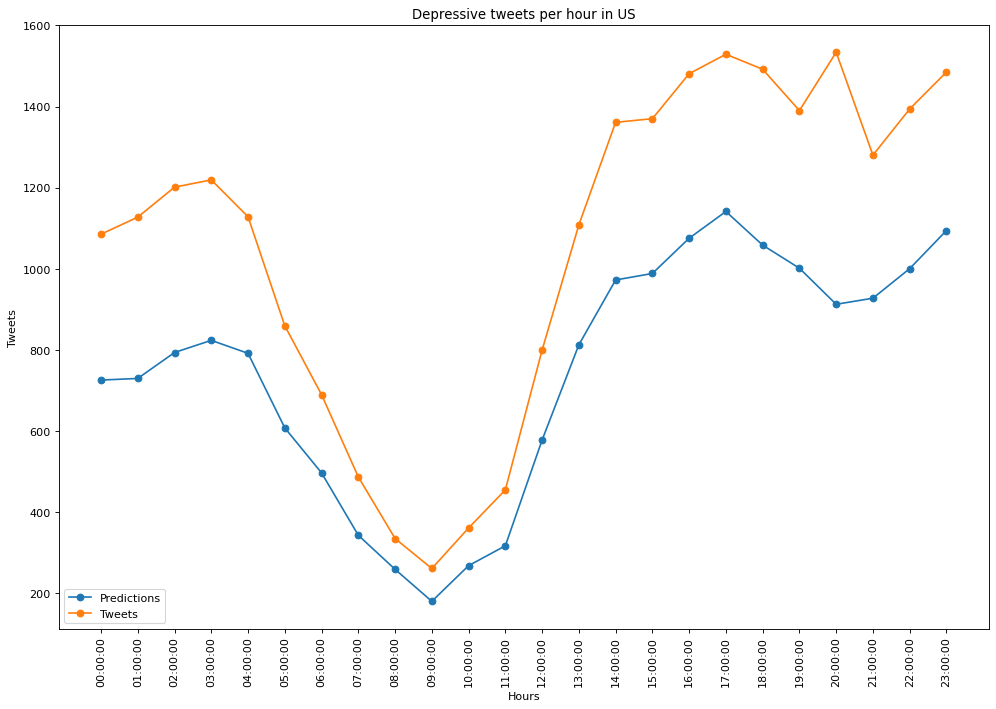

In [56]:
X_axis = ['00:00:00','01:00:00','02:00:00','03:00:00','04:00:00','05:00:00','06:00:00','07:00:00','08:00:00','09:00:00','10:00:00','11:00:00','12:00:00','13:00:00','14:00:00','15:00:00','16:00:00','17:00:00','18:00:00','19:00:00','20:00:00','21:00:00','22:00:00','23:00:00']
Y_axis = tweet_pred_per_hour['Label']

plt.figure(figsize=(15, 10), dpi=80)
plt.title('Depressive tweets per hour in US')
plt.plot(X_axis,Y_axis,marker='o')
plt.plot(X_axis,tweets_per_hour.values,marker='o')
plt.xlabel('Hours')
plt.ylabel('Tweets')
plt.xticks(rotation=90)
plt.legend(['Predictions','Tweets'],loc=3)
#plt.ylim(0, 3000)
plt.show()

There are a few things we can extract from the above's chart as well:

**As mentioned before, these are just assumptions and we would need to get more data about this, but some premature conclusions would be:**

* The depression/anxiety curves reach the bottom at 9:00 am, for obvious reasons like that's the time were there are less depressive/anxious tweets but also could be related factors like people is facing the job duties - most of them would be pretty busy.

* The curves reach the highest point at 17:00. This could be the time people unsatisfied with their jobs begin expressing their sentiment through Twitter. 

* 23:00 is also a very important peak: It could demonstrate how people express their their anxiety and depression before going to bed. We all know that's a very dramatic moment for depressive people.

To get a bigger panorama, more data from more days would need to be acquired.

# Conclusions

Alright, we've reached the end of this notebook. There are several things to highlight and also to close.

First of all I would say the models trained in here reached very good results even when the datasets were unbalanced. Also, even when they are pretty simple, could be implemented to identify several other topics such as violent, racist or abussive tweets, all of this with the goal of detect dangerous behaviors in the population or measure how hard an event impacts on it. We all know some companies are implementing this kind of models and apps to research about future employees before proceeding with the selection process.

Another important factor to highlight is that, prematurely saying, the first week of the lockdown decreased the depression and anxiety on the US population. We would need to research deeper, with more data for more days to know if actually the lockdown decresed depressive behavior. Also we identified important patterns such as weekens are less depressive days, and the most depressive day of the week is around Tuesday, just like most of the researches state. In addition, we've identified some important patterns during the day, such as the most depressive hour is 17:00 and 23:00, and the less depressive hour is 09:00 - we would need to research in more depth to know the reasons.

When talking about how this research can be improved, I would say more data needs to be acquired: More days before and after the lockdown and compare it with other countries, just to know if there are more important patterns. Another good approach would be to include some other keywords to the dataset, that way the classifier has a wider vocabulary. Finally, to normalize the results, I would get the same number of tweets for every day and every hour, that way we can get much more accurate data just basing us on the predictions and not on the tweets fluctuation.

Hope you've enjoyed the read. See you around!